<a href="https://colab.research.google.com/github/sdeutchman/watson/blob/Sarah/Copy_of_Copy_of_Watson_Elementary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import library 

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [4]:
 ! pip install -q kaggle

In [5]:
from google.colab import files

files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! mkdir submission


In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [7]:
train = pd.read_csv("/content/train/train.csv")

Exploring the dataset

In [8]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
train.shape

(12120, 6)

In [10]:
train.premise.values[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [11]:
train.hypothesis.values[1]

'Practice groups are not permitted to work on these issues.'

In [12]:
train.label.values[1]

2

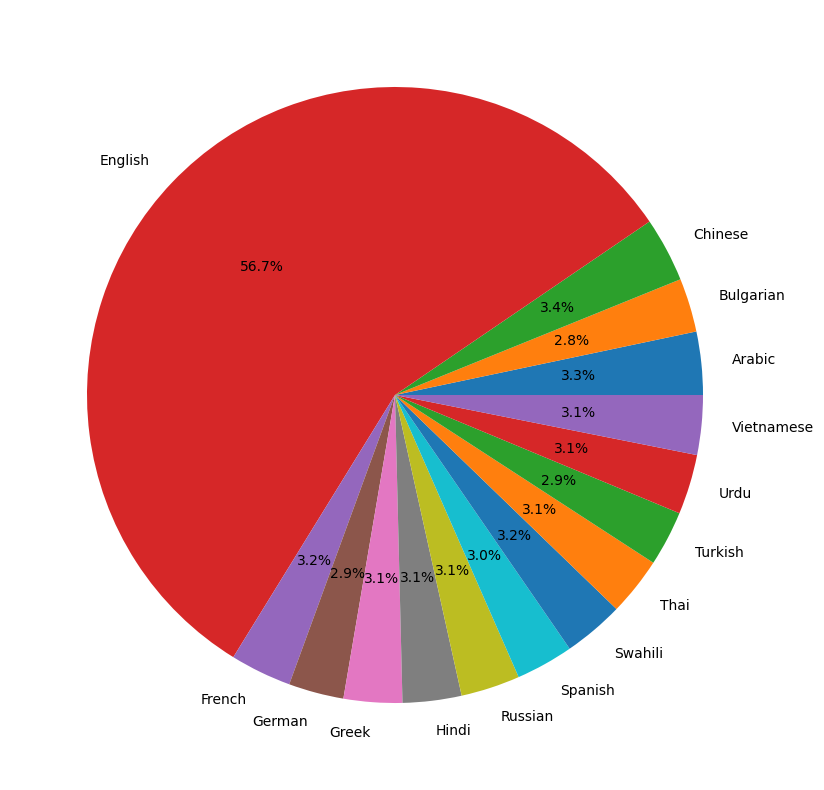

In [13]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

Preparing the Data

In [14]:


model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [15]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [16]:
encode_sentence("I love machine learning")


[146, 16138, 21432, 26901, 102]

In [17]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [18]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [19]:
max_len = 259

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

    

In [20]:
with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 259)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 32, validation_split = 0.2)

Epoch 1/2
